# Application of Downscaling Methods using Clmate Data as an example of Uganda International Education

## 1. Import required Python Libraries

In [1]:
import sys
import random

import xarray
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf

from CCdownscaling import correction_downscale_methods, distribution_tests, error_metrics, som_downscale, utilities

import warnings
warnings.filterwarnings("ignore")

# for reproducibility
seed = 1
random.seed(seed)

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/frame

## 2. Read Observation Weather data

* I couldn't find good quality weather data in Uganda, therefore, I used observation weather data that was provided by the original study to develop this downscaling method. https://egusphere.copernicus.org/preprints/2022/egusphere-2022-282/

In [2]:
# set downscaling variable and station id
downscaling_target='precip'
station_id='725300-94846'

In [3]:
# read observation weather data
station_data = pd.read_csv('./uganda/data/stations/' + station_id + '.csv')
station_data = station_data.replace(to_replace=[99.99, 9999.9], value=np.nan)
station_data

,Unnamed: 0,date,dew_point,max_temp,max_temp_flag,min_temp,min_temp_flag,precip,precip_flag,sea_level_pressure
0,0,1946-10-09,46.1,74.3,*,64.4,*,0.00,I,NaN
1,1,1946-10-10,52.4,80.2,*,53.4,*,0.00,I,NaN
2,2,1946-10-11,47.1,76.3,*,47.3,*,NaN,,NaN
3,3,1946-10-12,32.0,48.4,*,33.4,*,0.00,I,NaN
4,4,1946-10-13,32.7,65.3,*,29.3,*,0.00,I,NaN
...,...,...,...,...,...,...,...,...,...,...
26148,26148,2021-05-16,47.0,72.0,,55.0,,0.01,G,1021.1
26149,26149,2021-05-17,48.7,72.0,,55.0,,0.00,G,1021.0
26150,26150,2021-05-18,54.6,75.9,,55.9,,0.00,G,1022.1
26151,26151,2021-05-19,61.2,75.9,,57.9,,0.07,G,1021.1


In [4]:
station_lat = 0.3
station_lon = 32.6
station_lat, station_lon

(0.3, 32.6)

## 3. Read GCM historical data

In [5]:
# read five nc files
reanalysis_data = xarray.open_dataset('./uganda/data/models/pr_day_EC-Earth3-Veg-LR_historical_r1i1p1f1_gr_18500101-20141231_v20200217.nc')
reanalysis_data

<xarray.Dataset>
Dimensions:    (time: 60265, bnds: 2, lat: 8, lon: 9)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat        (lat) float64 -2.804 -1.682 -0.5607 0.5607 ... 2.804 3.925 5.047
  * lon        (lon) float64 27.0 28.12 29.25 30.38 31.5 32.62 33.75 34.88 36.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    contact:                cmip6-data@ec-earth.org
    creation_date:          2020-02-17T13:29:51Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.5.0
    branch_time_in_parent:  164359.0
    tracking_id:            hdl:21.14100/037c3f46-ad12-415a-bfaf-812c1bf9662f

### Remove Feb-29, Feb-30 considering leap years

In [6]:
start_year = 1850
end_year = 2014
leap_years = list(range(start_year + (4 - start_year % 4), end_year + 1, 4))
leap_years.remove(leap_years[12])
no_leap_years = list(range(start_year, end_year + 1, 1))
li = no_leap_years
remove_set = {3, 5}

li = [i for i in li if i not in leap_years]
li

[1850,
 1851,
 1853,
 1854,
 1855,
 1857,
 1858,
 1859,
 1861,
 1862,
 1863,
 1865,
 1866,
 1867,
 1869,
 1870,
 1871,
 1873,
 1874,
 1875,
 1877,
 1878,
 1879,
 1881,
 1882,
 1883,
 1885,
 1886,
 1887,
 1889,
 1890,
 1891,
 1893,
 1894,
 1895,
 1897,
 1898,
 1899,
 1900,
 1901,
 1902,
 1903,
 1905,
 1906,
 1907,
 1909,
 1910,
 1911,
 1913,
 1914,
 1915,
 1917,
 1918,
 1919,
 1921,
 1922,
 1923,
 1925,
 1926,
 1927,
 1929,
 1930,
 1931,
 1933,
 1934,
 1935,
 1937,
 1938,
 1939,
 1941,
 1942,
 1943,
 1945,
 1946,
 1947,
 1949,
 1950,
 1951,
 1953,
 1954,
 1955,
 1957,
 1958,
 1959,
 1961,
 1962,
 1963,
 1965,
 1966,
 1967,
 1969,
 1970,
 1971,
 1973,
 1974,
 1975,
 1977,
 1978,
 1979,
 1981,
 1982,
 1983,
 1985,
 1986,
 1987,
 1989,
 1990,
 1991,
 1993,
 1994,
 1995,
 1997,
 1998,
 1999,
 2001,
 2002,
 2003,
 2005,
 2006,
 2007,
 2009,
 2010,
 2011,
 2013,
 2014]

In [7]:
# remove Feb-30
for a_year in no_leap_years:
    reanalysis_data = reanalysis_data.sel(time=~((reanalysis_data.time.dt.year == a_year) & (reanalysis_data.time.dt.month == 2) & (reanalysis_data.time.dt.day == 30)))

In [8]:
# remove Feb-29
for a_year in li:
    reanalysis_data = reanalysis_data.sel(time=~((reanalysis_data.time.dt.year == a_year) & (reanalysis_data.time.dt.month == 2) & (reanalysis_data.time.dt.day == 29)))

## 4. Change precipitation unit and extract data using lat and lon

In [9]:
# load GCM historical data
reanalysis_data['pr'] = reanalysis_data['pr'] * 86400
rean_precip = reanalysis_data['pr'].sel(lat=station_lat, lon=station_lon, method='nearest').values
rean_precip = np.squeeze(rean_precip)

## 5. Select the station data to match the time from the GCM data

In [10]:
# select the station data to match the time from the reanalysis data
start = reanalysis_data['time'][0].values
end = reanalysis_data['time'][-1].values
station_data['time'] = pd.to_datetime(station_data['date'], format='%Y-%m-%d')
date_mask = ((station_data['time'] >= start) & (station_data['time'] <= end))
station_data = station_data[date_mask]
station_data

,Unnamed: 0,date,dew_point,max_temp,max_temp_flag,min_temp,min_temp_flag,precip,precip_flag,sea_level_pressure,time
0,0,1946-10-09,46.1,74.3,*,64.4,*,0.0,I,NaN,1946-10-09
1,1,1946-10-10,52.4,80.2,*,53.4,*,0.0,I,NaN,1946-10-10
2,2,1946-10-11,47.1,76.3,*,47.3,*,NaN,,NaN,1946-10-11
3,3,1946-10-12,32.0,48.4,*,33.4,*,0.0,I,NaN,1946-10-12
4,4,1946-10-13,32.7,65.3,*,29.3,*,0.0,I,NaN,1946-10-13
...,...,...,...,...,...,...,...,...,...,...,...
23816,23816,2014-12-27,39.2,50.0,,34.0,,0.0,G,1016.0,2014-12-27
23817,23817,2014-12-28,19.3,48.9,,21.9,,0.0,G,1021.1,2014-12-28
23818,23818,2014-12-29,18.3,35.1,,23.0,,0.0,G,1026.8,2014-12-29
23819,23819,2014-12-30,4.3,30.0,,9.0,,0.0,G,1035.8,2014-12-30


In [11]:
hist_data = station_data[downscaling_target].values
# Convert units, in/day to mm/day for precip
hist_data = hist_data * 2.54

In [12]:
# For just a single grid point:
# reanalysis_data = reanalysis_data.sel(lat = station_lat, lon = station_lon, method='nearest')
# To use multiple grid points in a window around the location:
window = 2
lat_index = np.argmin(np.abs(reanalysis_data['lat'].values - station_lat))
lon_index = np.argmin(np.abs(reanalysis_data['lon'].values - station_lon))
reanalysis_data = reanalysis_data.isel({'lat': slice(lat_index - window, lat_index + window + 1),
                                        'lon': slice(lon_index - window, lon_index + window + 1)})
reanalysis_data

In [14]:
var_data = reanalysis_data['pr'].values
input_data = var_data.reshape(var_data.shape[0], var_data.shape[1] * var_data.shape[2])
input_data = np.array(input_data)
input_data

array([[ 1.05528823e+01,  7.61437418e+00,  8.59498959e+00, ...,
        -1.22409109e-19, -1.22409109e-19, -1.22409109e-19],
       [ 6.29186640e+00,  1.06668469e+00,  4.39882265e-01, ...,
        -4.99601382e-20, -4.99601382e-20, -4.99601382e-20],
       [ 3.69310352e+00,  1.90734857e-03,  1.28746033e-02, ...,
        -5.58148234e-20, -5.58148234e-20, -5.58148234e-20],
       ...,
       [ 3.77178193e+00,  1.64198874e+00,  1.84924590e+01, ...,
         6.39438616e-01,  4.43458535e-01,  1.46269795e+00],
       [ 2.72512415e+00,  2.98786161e+00,  2.38342275e+01, ...,
         7.66277307e-01,  1.19447707e+00,  7.33375561e-01],
       [ 3.14044955e+00,  7.80677784e+00,  2.82464018e+01, ...,
         1.10101699e+00,  8.80241356e-01,  3.82423376e-01]])

In [15]:
# Drop days with NaN values for the observation:
hist, rean_precip = utilities.remove_missing(hist_data, rean_precip)
hist_data, input_data = utilities.remove_missing(hist_data, input_data)

input_data, input_means, input_stdevs = utilities.normalize_climate_data(input_data)
input_data, input_means, input_stdevs

(array([[ 1.21685462,  1.55730678,  0.67343879, ..., -0.60613161,
         -0.41859799, -0.3607889 ],
        [ 0.39710572, -0.25420782, -0.56539004, ..., -0.60613161,
         -0.41859799, -0.3607889 ],
        [ 0.64158092, -0.3294045 ,  0.35624351, ..., -0.60613161,
         -0.28967962, -0.18953454],
        ...,
        [ 0.95407823, -0.50413786, -0.63105286, ..., -0.60613161,
         -0.41859799, -0.3607889 ],
        [ 0.47856685, -0.51330657, -0.63206695, ..., -0.60613161,
         -0.41859799, -0.3607889 ],
        [ 0.08098491, -0.54490237, -0.63221183, ..., -0.60613161,
         -0.41859799, -0.3607889 ]]),
 array([4.22772971, 1.98551464, 4.16179797, 2.29062701, 1.50828464,
        1.727074  , 2.86370728, 5.31735989, 3.99399894, 2.39679463,
        1.97403282, 3.15553493, 2.25567419, 4.76443165, 3.44020422,
        2.91775266, 2.04271617, 2.2509561 , 2.32086883, 1.31250341,
        3.98875251, 2.52241532, 2.59594874, 1.25721171, 1.18640098]),
 array([5.19795256, 3.61448342,

## 6. Split train and test sets

In [16]:
# split train and test sets:
# train_split = int(round(input_data.shape[0]*0.8))
train_split = 17150  # split out the first 24 years for the training data, last 6 years for the test set
training_data = input_data[0:train_split, :]
train_hist = hist_data[0:train_split]
test_data = input_data[train_split:, :]
test_hist = hist_data[train_split:]
rean_precip_train = rean_precip[0:train_split]
rean_precip_test = rean_precip[train_split:]
print(training_data.shape, test_data.shape)

(17150, 25) (4288, 25)


In [17]:
# intialize the different methods
som = som_downscale(som_x=7, som_y=5, batch=512, alpha=0.1, epochs=50)
rf_two_part = correction_downscale_methods.two_step_random_forest()
random_forest = sklearn.ensemble.RandomForestRegressor()
qmap = correction_downscale_methods.quantile_mapping()
linear = sklearn.linear_model.LinearRegression()

## 7. Train Climate Data

In [18]:
# train
som.fit(training_data, train_hist, seed=1)
random_forest.fit(training_data, train_hist)
rf_two_part.fit(training_data, train_hist)
linear.fit(training_data, train_hist)
qmap.fit(rean_precip_train, train_hist)


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.










2022-08-21 23:07:45.672192: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-08-21 23:07:45.676568: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3099995000 Hz
2022-08-21 23:07:45.678028: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55814a981ca0 executing computations on platform Host. Devices:
2022-08-21 23:07:45.678103: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-08-21 23:07:45.894316: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not 

time to train for 50 epochs:  10.634036540985107
(5137, 25) (5137,)


array([-5.82529973e-19, -5.67887101e-19, -3.43336868e-19, ...,
        1.74489683e+01,  1.09161023e+01,  5.74384357e+00])

## 8. Test and Visualize Climate data 

In [19]:
# generate outputs from the test data
som_output = som.predict(test_data)
random_forest_output = random_forest.predict(test_data)
rf_two_part_output = rf_two_part.predict(test_data)
linear_output = linear.predict(test_data)
qmap_output = qmap.predict(rean_precip_test)

In [20]:
# Include the reanalysis precipitation as an undownscaled comparison
names = ['SOM', 'Random Forest', 'RF Two Part', 'Linear', 'Qmap', 'NCEP']
outputs = [som_output, random_forest_output, rf_two_part_output, linear_output, qmap_output, rean_precip_test]

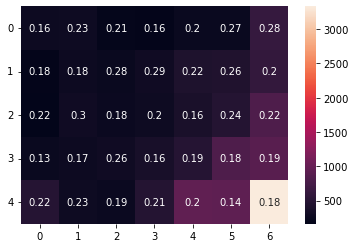

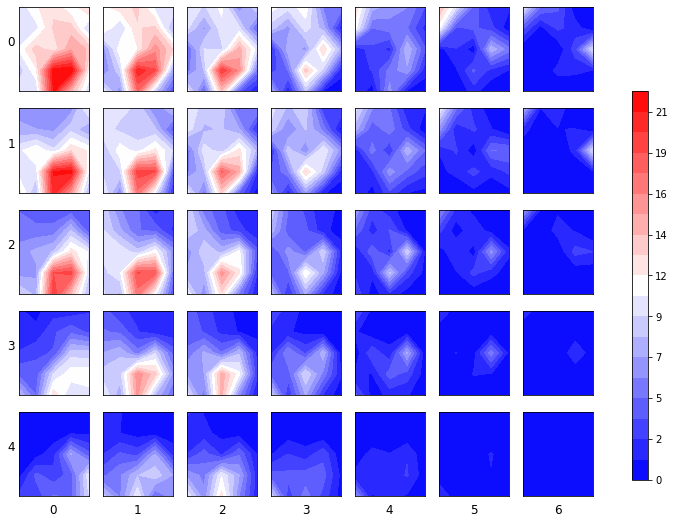

In [21]:
# run analyses for the downscaled outputs

# first, the som specific plots
freq, avg, dry = som.node_stats()
ax = som.heat_map(training_data, annot=avg)
plt.yticks(rotation=0)
plt.savefig('example_figures/ohare_heatmap_5x7_' + downscaling_target + '.png')
plt.show()
plt.close()
i = 0
index_range = (window * 2 + 1) ** 2
input_vars = ["pr"]
for var in input_vars:
    start_index = i * index_range
    end_index = (i + 1) * index_range
    fig, ax, cbar = som.plot_nodes(weights_index=(start_index, end_index), means=input_means[start_index:end_index],
                                   stdevs=input_stdevs[start_index:end_index], cmap='bwr')
    for axis in ax.flatten():
        axis.set_xticks([])
        axis.set_yticks([])

    for axis, col in zip(ax[-1], range(0, som.som_x)):
        axis.set_xlabel(col, size='large')
    for axis, row in zip(ax[:, 0], range(0, som.som_y)):
        axis.set_ylabel(row, rotation=0, size='large')
    # fig.suptitle(var)
    #units = {'air': '(K)', 'rhum': '(%)', 'uwnd': r'(ms$^{-1}$)', 'vwnd': r'(ms$^{-1}$)', 'hgt': '(m)'}
    #cbar.set_label(var.capitalize() + ' ' + units[var], rotation='horizontal', labelpad=20)
    fig.savefig('example_figures/SOM_nodes_NCEP_' + var + '.png')
    plt.show()
    plt.close()
    i += 1

In [22]:
def plot_kde(outputs, names, hist_data, scores, downscaling_target):
	i = 0
	fig, ax = plt.subplots(nrows=1, ncols=1)
	for output in outputs:
		sns.kdeplot(output, label=names[i] + ' ' + str(scores[names[i]][0]), ax=ax)
		i += 1
	sns.kdeplot(hist_data, color='k', lw=2.0, label='Obs', ax=ax)
	if downscaling_target == 'max_temp':
		plt.xlabel(r'Daily Max Temperature ($^\circ$C)')
	elif downscaling_target == 'precip':
		plt.xlabel(r'PRCP ($10^x$ mm/day)')
	return fig, ax

In [23]:
def plot_histogram(outputs, names, hist_data):
	fig, ax = plt.subplots(nrows=1, ncols=1)
	bin_starts = np.array([0, 0.01, .1, .25, .75, 2, 10]) * 25.4
	outputs.append(hist_data)
	names.append('Obs')
	ax.hist(outputs, bins=bin_starts, label=names, density=True, rwidth=.4, log=True)
	plt.xscale("log")
	logfmt = matplotlib.ticker.LogFormatterExponent(base=10.0, labelOnlyBase=True)
	ax.xaxis.set_major_formatter(logfmt)
	plt.xlabel(r'PRCP ($10^x$ mm/day)')
	ax.yaxis.set_major_formatter(logfmt)
	plt.ylabel(r'Frequency ($10^x$)')
	ax.tick_params(axis='both')
	ax.legend()
	return fig, ax

In [24]:
def plot_autocorrelation(outputs, names, hist_data, nlags=10):
	# plot the autocorrelation function for the different downscaling outputs.
	fig, ax = plt.subplots(nrows=1, ncols=1)
	i = 0
	for output in outputs:
		auto_corr = acf(output, nlags=nlags)
		ax.plot(auto_corr, label=names[i])
		i += 1

	obs_corr = acf(hist_data, nlags=nlags)
	ax.plot(obs_corr, label='Obs', color='k')
	ax.set_xlabel('Lag Time (days)')
	ax.set_ylabel('Correlation')
	ax.legend(ncol=2)
	return fig, ax

SOM 0.98 0.13 1.1 0.09
Random Forest 0.938 0.66 0.93 0.04
RF Two Part 0.936 0.36 0.96 0.28
Linear 0.936 0.73 0.92 0.09
Qmap 0.988 0.62 1.27 -0.13
NCEP 0.719 0.43 4.65 -2.14


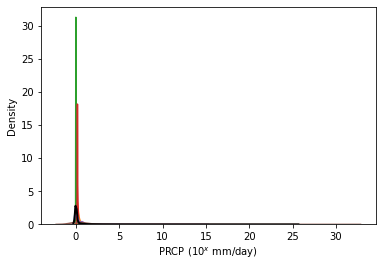

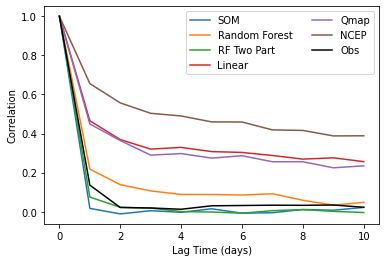

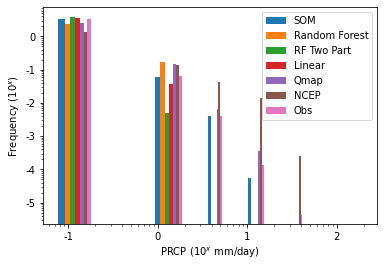

In [25]:
# next, the various skill metric scores
scores = {}
np.set_printoptions(precision=2, suppress=True)
i = 0
for output in outputs:
    pdf_score = distribution_tests.pdf_skill_score(output, test_hist)
    ks_stat, ks_probs = distribution_tests.ks_testing(output, test_hist)
    rmse = sklearn.metrics.mean_squared_error(test_hist, output, squared=False)
    bias = error_metrics.calc_bias(output, test_hist)

    print(names[i], round(pdf_score, 3), round(ks_stat, 2), round(rmse, 2), round(bias, 2))
    scores[names[i]] = [round(pdf_score, 3), round(ks_stat, 2), round(rmse, 2), round(bias, 2)]
    i += 1

# finally, some plots comparing the outputs
fig, ax = plot_kde(outputs, names, hist_data, scores, downscaling_target)
plt.savefig('example_figures/ohare_' + downscaling_target + '_methods_compare_kde.png')
plt.show()

fig, ax = plot_autocorrelation(outputs, names, hist_data)
plt.savefig('example_figures/ohare_' + downscaling_target + '_methods_compare_autocorr.png')
plt.show()

fig, ax = plot_histogram(outputs, names, hist_data)
plt.savefig('example_figures/ohare_' + downscaling_target + '_methods_compare_histogram.png')
plt.show()

## 9. Create Future Precipitations

In [ ]:
# read five nc files
scenario_data = xarray.open_dataset('./uganda/data/models/pr_day_EC-Earth3-Veg-LR_ssp370_r1i1p1f1_gr_20220101-21001231_v20201123.nc')
scenario_data

In [93]:
test_data.shape

(4288, 25)

In [94]:
# For just a single grid point:
# reanalysis_data = reanalysis_data.sel(lat = station_lat, lon = station_lon, method='nearest')
# To use multiple grid points in a window around the location:
window = 2
lat_index = np.argmin(np.abs(scenario_data['lat'].values - station_lat))
lon_index = np.argmin(np.abs(scenario_data['lon'].values - station_lon))
scenario_data = scenario_data.isel({'lat': slice(lat_index - window, lat_index + window + 1),
                                        'lon': slice(lon_index - window, lon_index + window + 1)})

In [95]:
scenario_data

<xarray.Dataset>
Dimensions:    (time: 28854, bnds: 2, lat: 5, lon: 5)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01T12:00:00 ... 2100-12-31T12:00:00
  * lat        (lat) float64 -1.682 -0.5607 0.5607 1.682 2.804
  * lon        (lon) float64 30.38 31.5 32.62 33.75 34.88
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 2022-01-01 2022-01-02 ... 2101-01-01
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP AerChemMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    title:                              EC-Earth3-Veg-LR output prepared for ...
    tracking_id:                        hdl:21.14100/b09f3840-378e-4f67-a245-...
    variable_id:                        pr
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

In [97]:
#reanalysis_data['pr'] = reanalysis_data['pr'] * 86400
var_data = scenario_data['pr'].values * 86400
input_data = var_data.reshape(var_data.shape[0], var_data.shape[1] * var_data.shape[2])
input_data = np.array(input_data)
input_data

array([[ 8.02,  9.16, 13.09, ...,  9.52,  0.43,  0.77],
       [ 9.  ,  6.86, 12.68, ...,  9.53,  1.82,  0.97],
       [ 2.07,  2.15,  6.96, ...,  1.47,  0.28, -0.  ],
       ...,
       [ 8.2 , 10.25,  8.26, ...,  2.46, -0.  ,  0.  ],
       [ 6.36,  6.27, 14.17, ...,  1.06, -0.  ,  0.19],
       [12.61,  5.56, 13.28, ..., -0.  , -0.  ,  0.44]])

In [98]:
input_data.shape

(28854, 25)

In [99]:
# Drop days with NaN values for the observation:
hist, rean_precip = utilities.remove_missing(hist_data, rean_precip)
hist_data, input_data = utilities.remove_missing(hist_data, input_data)

input_data, input_means, input_stdevs = utilities.normalize_climate_data(input_data)

In [ ]:
# generate outputs from the test data
som_output = som.predict(input_data)
random_forest_output = random_forest.predict(input_data)
rf_two_part_output = rf_two_part.predict(input_data)
linear_output = linear.predict(input_data)
qmap_output = qmap.predict(input_data)

In [ ]:
som_output